In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.legend_handler import HandlerTuple
from matplotlib.markers import MarkerStyle
import tensorflow as tf
import pickle
from pathlib import Path
from dataclasses import dataclass
from mbeml.constants import LigandFeatures, TargetProperty
from mbeml.featurization import data_prep
from mbeml.plotting import (
    color_dict,
    marker_dict,
    interpolation_plot,
    interpolation_scatter,
)

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data/")

df_train = pd.read_csv(data_dir / "training_data.csv")
df_val = pd.read_csv(data_dir / "validation_data.csv")

model_dir = Path("../../models/")

In [4]:
A = "methanol"
B = "hydrogencyanide"
C = "hydrogenisocyanide"
df_heteroleptic = pd.read_csv(data_dir / "composition_test_data.csv")

In [5]:
df_homoleptic = pd.read_csv(data_dir / "training_data.csv")
df_homoleptic["name"] = df_homoleptic["name"].str.replace(
    "[C+]#[NH-]", "hydrogenisocyanide", regex=False
)
df_homoleptic = df_homoleptic[
    (
        df_homoleptic["name"].str.contains("_".join([A] * 6), regex=False)
        | df_homoleptic["name"].str.contains("_".join([B] * 6), regex=False)
        | df_homoleptic["name"].str.contains("_".join([C] * 6), regex=False)
    )
]
assert len(df_homoleptic) == 24
df_full = pd.concat([df_homoleptic, df_heteroleptic])

In [6]:
ligs = np.stack(df_full["name"].apply(lambda x: x.split("_")[2:]).values)
N_A = np.sum(ligs == A, axis=-1, keepdims=True)
N_B = np.sum(ligs == B, axis=-1, keepdims=True)
N_C = np.sum(ligs == C, axis=-1, keepdims=True)

cores = df_full[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
unique_cores = np.unique(cores)

In [7]:
@dataclass
class Experiment:
    name: str
    features: LigandFeatures
    target: TargetProperty = TargetProperty.SSE
    is_nn: bool = False
    prediction = np.zeros([len(df_full), 1])

In [8]:
krr_experiments = [
    Experiment("krr_standard_racs", features=LigandFeatures.STANDARD_RACS),
    Experiment("krr_two_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("krr_three_body", features=LigandFeatures.LIGAND_RACS),
]
nn_experiments = [
    Experiment("nn_standard_racs", features=LigandFeatures.STANDARD_RACS, is_nn=True),
    Experiment("nn_two_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
    Experiment("nn_three_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
]
experiments = krr_experiments + nn_experiments

In [9]:
for experiment in experiments:
    X, _ = data_prep(df_full, experiment.features, experiment.target, experiment.is_nn)
    # Evaluate model
    if experiment.is_nn:
        model = tf.keras.models.load_model(
            model_dir / experiment.target.name.lower() / experiment.name
        )
        # First element because uncertainty is not needed
        experiment.prediction = model.predict(X, verbose=0)[0]
    else:
        with open(
            model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
            "rb",
        ) as fin:
            model = pickle.load(fin)
        experiment.prediction = model.predict(X)

2024-02-16 14:40:26.660564: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [10]:
def XY_curve(core, X, Y):
    indices = []
    x_vec = []
    for i in range(0, 6):
        if i == 2:
            # First cis
            ind_cis = np.where(
                (cores == core) & (ligs == [X, X, X, Y, X, Y]).all(axis=1)
            )[0]
            # then trans
            ind_trans = np.where(
                (cores == core) & (ligs == [X] * 4 + [Y] * 2).all(axis=1)
            )[0]
            inds = [ind_cis[0], ind_trans[0]]
        elif i == 3:
            # First fac
            ind_fac = np.where(
                (cores == core)
                & (
                    (ligs == [X, X, Y, Y, X, Y]).all(axis=1)
                    | (ligs == [X, X, Y, Y, Y, X]).all(axis=1)
                    | (ligs == [Y, Y, X, X, Y, X]).all(axis=1)
                    | (ligs == [Y, Y, X, X, X, Y]).all(axis=1)
                )
            )[0]
            # then mer
            ind_mer = np.where(
                (cores == core)
                & (
                    (ligs == [X] * 3 + [Y] * 3).all(axis=1)
                    | (ligs == [Y] * 3 + [X] * 3).all(axis=1)
                )
            )[0]
            inds = [ind_fac[0], ind_mer[0]]
        elif i == 4:
            # First cis
            ind_cis = np.where(
                (cores == core) & (ligs == [Y, Y, Y, X, Y, X]).all(axis=1)
            )[0]
            # then trans
            ind_trans = np.where(
                (cores == core) & (ligs == [Y] * 4 + [X] * 2).all(axis=1)
            )[0]
            inds = [ind_cis[0], ind_trans[0]]
        else:
            inds = np.where(
                (cores == core)
                & (
                    (ligs == [X] * (6 - i) + [Y] * i).all(axis=1)
                    | (ligs == [Y] * i + [X] * (6 - i)).all(axis=1)
                )
            )[0]
        indices.extend(inds)
        x_vec.extend(i * np.ones_like(inds))
    return indices, x_vec


def interp_curve(core):
    indices = []
    x_vec = []

    for X, Y, i0 in [(A, B, 0), (B, C, 6), (C, A, 12)]:
        inds, xs = XY_curve(core, X, Y)
        indices.extend(inds)
        x_vec.extend([i0 + xi for xi in xs])
    # Add the final A (closing the loop)
    indices.append(indices[0])
    x_vec.append(18)

    return indices, np.array(x_vec)

In [11]:
label_dict = {
    core: f"{core[:2].capitalize()}({'I'*int(core[-1])})" for core in unique_cores
}

alpha = 0.8
alpha_cis = 0.4
alpha_trans = alpha
scatter_kwargs = {
    "clip_on": False,
    "zorder": 3,
    "alpha": alpha,
    "s": 25,
    "edgecolors": "none",
}
plot_kwargs = {"linewidth": 0.9, "zorder": 0.5}


def base_plot(
    cores_to_plot, experiments, target=TargetProperty.SSE, lowerlim=-50, upperlim=85
):
    key = target.full_name()

    fig = plt.figure(figsize=(3.33, 4.44))
    axes = fig.subplots(
        nrows=3,
        sharex=True,
        sharey=True,
        gridspec_kw=dict(
            hspace=0.0,
            left=0.16,
            right=0.90,
            top=0.97,
            bottom=0.06,
        ),
    )

    ax = axes[0]
    # Set all the ticks/labels/annotations of the plot
    for ax, label in zip(axes, ["standard-RACs", "two-body", "three-body"]):
        ax.axvline(6, color="k", linestyle="--", zorder=0.0)
        ax.axvline(12, color="k", linestyle="--", zorder=0.0)
        ax.axhline(0, color="k", linewidth=0.5, zorder=0.0)
        ax.set_ylabel("$\Delta E_\mathrm{H-L}$ (kcal/mol)")
        ax.yaxis.set_ticks_position("both")
        # Label the right side with the model type
        ax.text(
            19,
            0.5 * (lowerlim + upperlim),
            label,
            rotation=90,
            fontsize=9,
            verticalalignment="center",
        )
    # The next few options are just set on one ax element
    # because those properties are shared anyway
    ax.set_xlim(0, 18)
    ax.set_ylim(lowerlim, upperlim)
    ax.set_xticks(range(19), minor=True)
    ax.set_xticks([0, 6, 12, 18])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set_xticklabels(
        [
            "(MeOH)$_6$",
            "(NCH)$_6$",
            "(CNH)$_6$",
            "(MeOH)$_6$",
        ],
    )

    # Plot scatters and lines
    for ax, experiment in zip(axes, experiments):
        for core in cores_to_plot:
            indices, x = interp_curve(core)
            interpolation_scatter(
                ax,
                x,
                df_full.iloc[indices][key],
                color=color_dict[core[:-1]],
                marker=marker_dict[core[-1]],
                alpha_cis=alpha_cis,
                alpha_trans=alpha_trans,
                **scatter_kwargs,
            )
            interpolation_plot(
                ax,
                x,
                experiment.prediction[indices],
                color=color_dict[core[:-1]],
                alpha_cis=alpha_cis,
                alpha_trans=alpha_trans,
                **plot_kwargs,
            )
    return fig, axes


def four_metal_plot(cores_to_plot, experiments, **kwargs):
    fig, axes = base_plot(cores_to_plot, experiments, **kwargs)
    # Add Legend
    # First for cores
    ax = axes[0]
    handles = []
    labels = []
    for core in cores_to_plot:
        p = ax.scatter(
            [],
            [],
            color=color_dict[core[:2]],
            marker=marker_dict[core[-1]],
            **dict(scatter_kwargs, clip_on=True),
        )
        handles.append(p)
        labels.append(label_dict[core])
    ax.legend(
        handles,
        labels,
        loc="upper left",
        ncols=4,
        markerscale=0.95,
        bbox_to_anchor=(0.0, 1.10),
        handlelength=1.3,
        handletextpad=0.2,
        columnspacing=0.5,
    )

    # Then for isomers
    ax = axes[1]
    isomer_handles = []
    isomer_labels = ["cis/fac", "trans/mer"]

    for fillstyle, linestyle, alpha in [
        ("left", (0, (2, 1)), alpha_cis),
        ("right", (0, (1, 2)), alpha_trans),
    ]:
        markers = tuple(
            ax.scatter(
                [],
                [],
                marker=MarkerStyle(marker_dict[ox], fillstyle=fillstyle),
                edgecolors="k",
                facecolor="none",
                linewidth=0.5,
                alpha=alpha,
                s=20,
            )
            for ox in ["2", "3"]
        )
        # Add the line
        (line,) = ax.plot([], [], linestyle=linestyle, color="k", alpha=alpha)
        isomer_handles.append((line, markers))

    ax.legend(
        isomer_handles,
        isomer_labels,
        markerscale=1.0,
        handler_map={
            isomer_handles[-2]: HandlerTuple(),
            isomer_handles[-1]: HandlerTuple(),
            tuple: HandlerTuple(ndivide=2, pad=0.0),
        },
        loc="upper left",
        handlelength=1.3,
        handletextpad=0.2,
        scatteryoffsets=[0.5],
    )
    return fig, axes


def two_metal_plot(cores_to_plot, experiments, **kwargs):
    fig, axes = base_plot(cores_to_plot, experiments, **kwargs)
    # Add Legend
    # First for cores
    ax = axes[0]
    handles = []
    labels = []
    for core in cores_to_plot:
        p = ax.scatter(
            [],
            [],
            color=color_dict[core[:2]],
            marker=marker_dict[core[-1]],
            **dict(scatter_kwargs, clip_on=True),
        )
        handles.append(p)
        labels.append(label_dict[core])
    ax.legend(
        handles,
        labels,
        loc="upper left",
        markerscale=0.95,
        handlelength=1.3,
        handletextpad=0.2,
    )

    # Then for isomers
    ax = axes[1]
    isomer_handles = []
    isomer_labels = ["cis/fac", "trans/mer"]

    for fillstyle, linestyle, alpha in [
        ("left", (0, (2, 1)), alpha_cis),
        ("right", (0, (1, 2)), alpha_trans),
    ]:
        markers = tuple(
            ax.scatter(
                [],
                [],
                marker=MarkerStyle(marker_dict[ox], fillstyle=fillstyle),
                edgecolors="k",
                facecolor="none",
                linewidth=0.5,
                alpha=alpha,
                s=20,
            )
            for ox in ["2", "3"]
        )
        # Add the line
        (line,) = ax.plot([], [], linestyle=linestyle, color="k", alpha=alpha)
        isomer_handles.append((line, markers))

    ax.legend(
        isomer_handles,
        isomer_labels,
        markerscale=1.0,
        handler_map={
            isomer_handles[-2]: HandlerTuple(),
            isomer_handles[-1]: HandlerTuple(),
            tuple: HandlerTuple(ndivide=2, pad=0.0),
        },
        loc="upper left",
        handlelength=1.3,
        handletextpad=0.2,
        scatteryoffsets=[0.5],
    )
    return fig, axes

# KRR

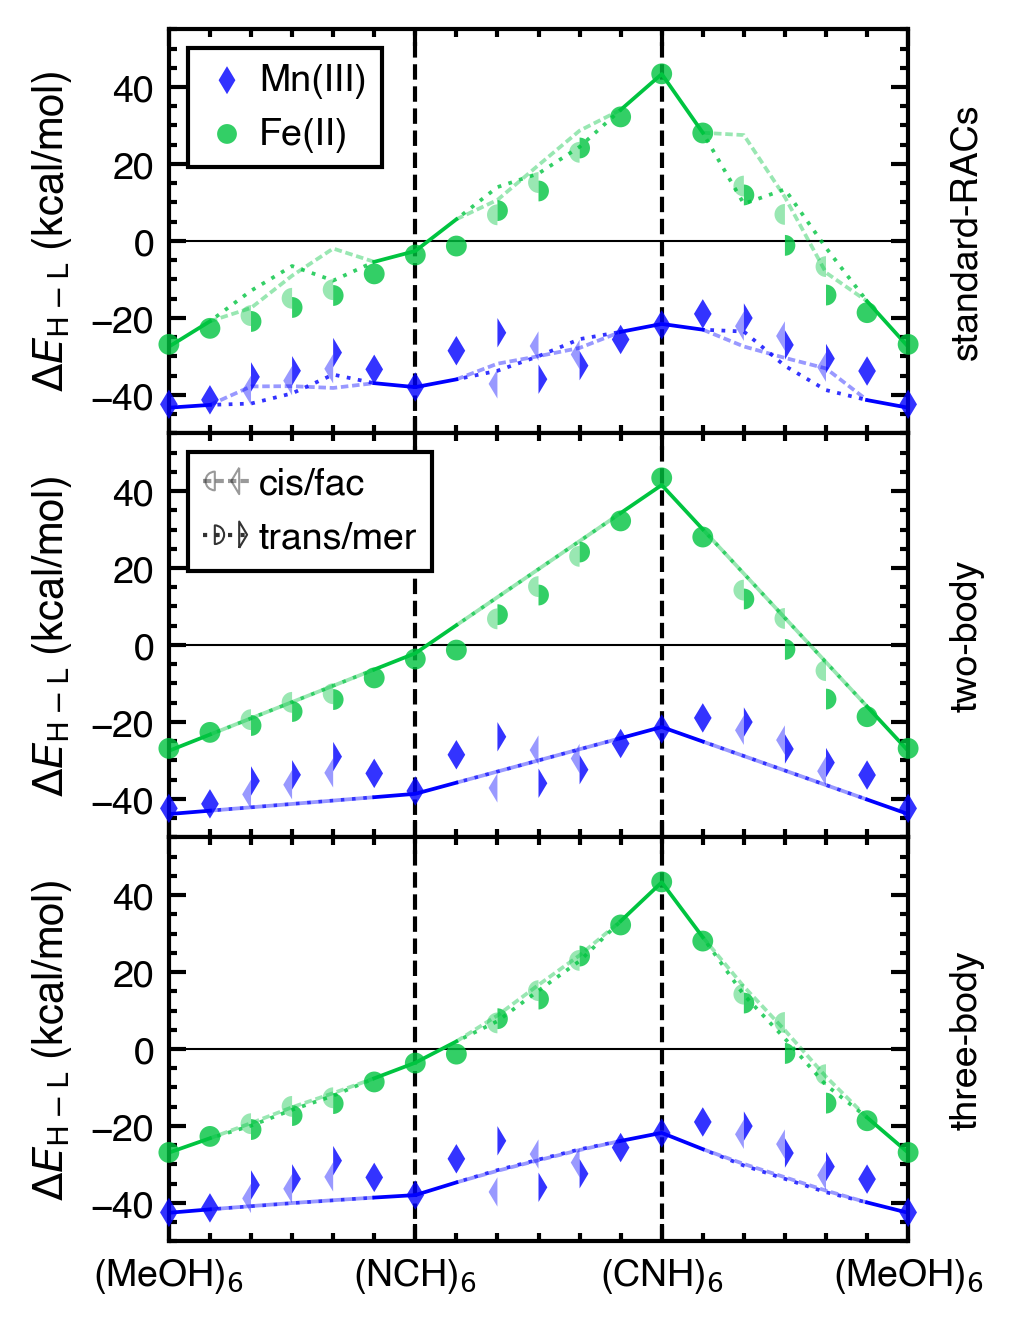

In [12]:
fig, _ = two_metal_plot(["mn3", "fe2"], krr_experiments, lowerlim=-50, upperlim=55)
fig.savefig("plots/interpolation_plot_sse_krr_1.pdf")

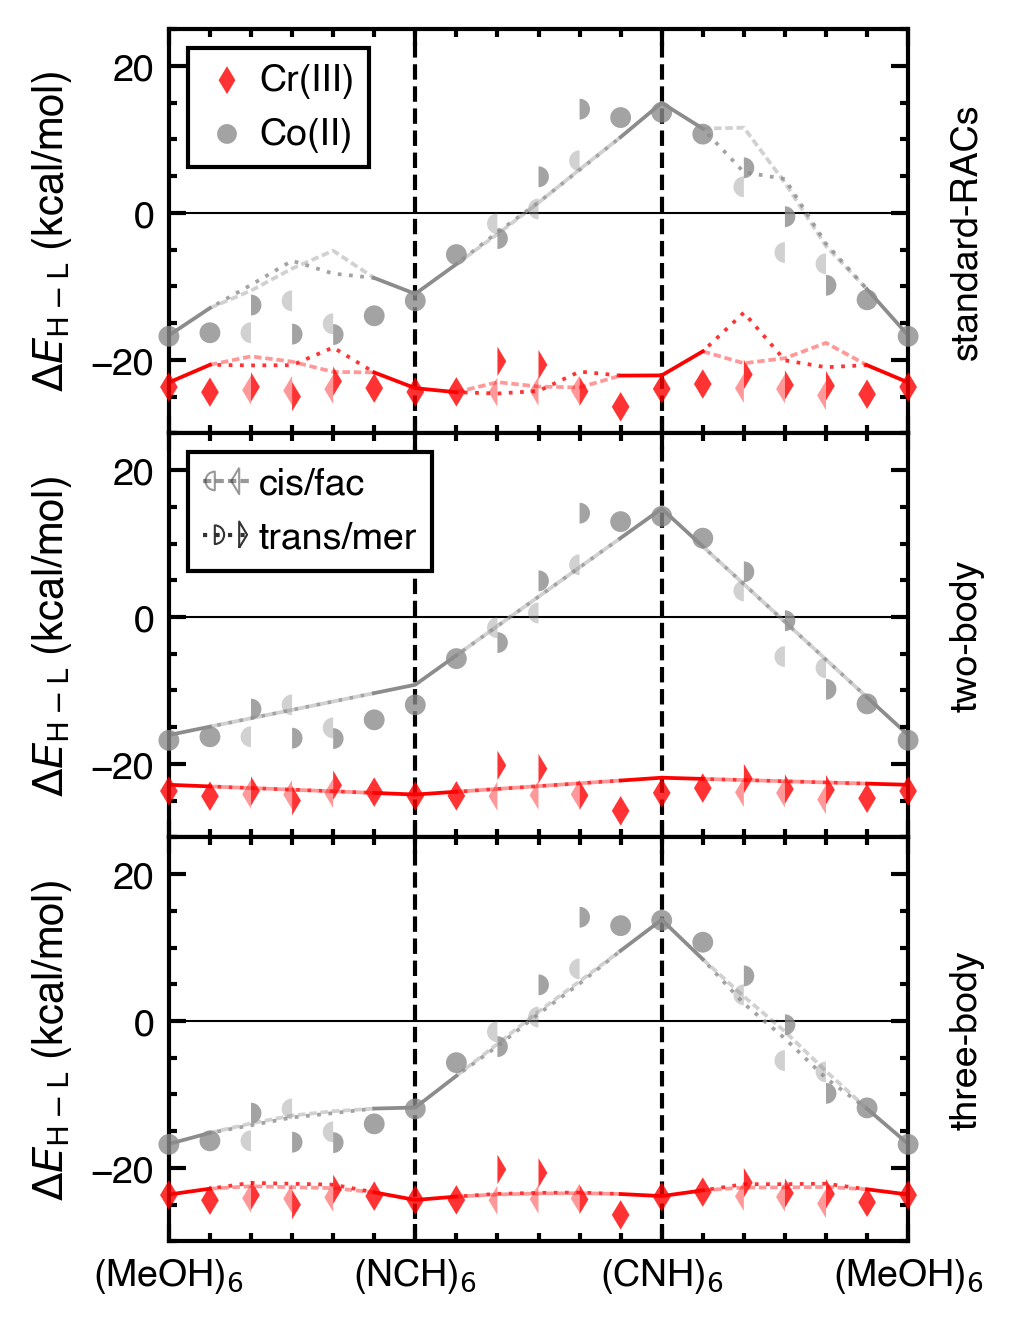

In [13]:
fig, _ = two_metal_plot(["cr3", "co2"], krr_experiments, lowerlim=-30, upperlim=25)
fig.savefig("plots/interpolation_plot_sse_krr_2.pdf")

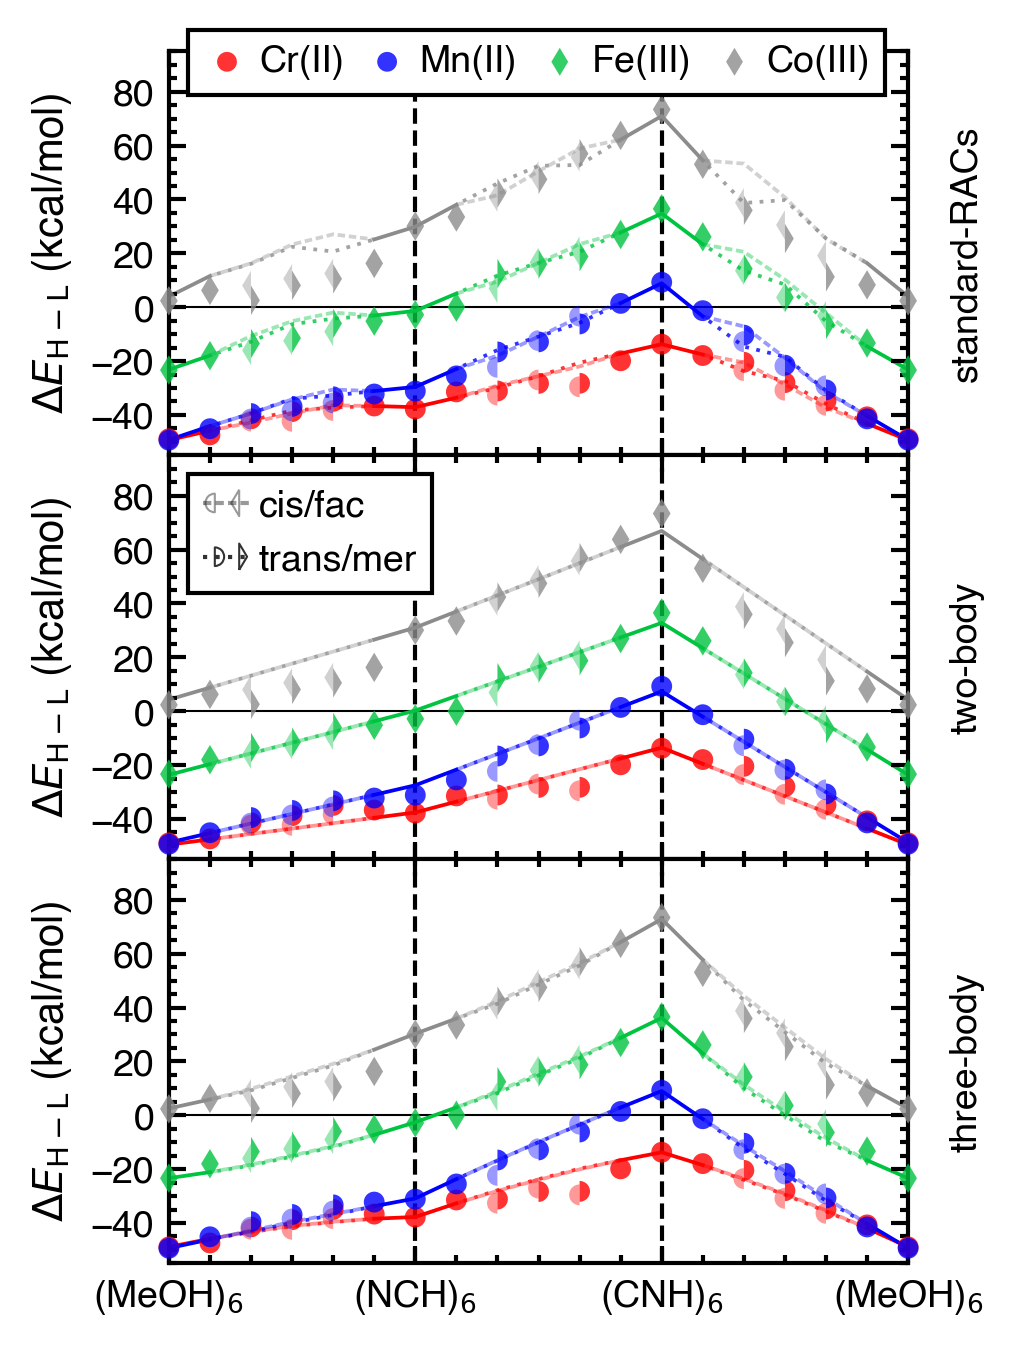

In [14]:
fig, _ = four_metal_plot(
    ["cr2", "mn2", "fe3", "co3"], krr_experiments, lowerlim=-55, upperlim=95
)
fig.savefig("plots/interpolation_plot_sse_krr_3.pdf")

# NN

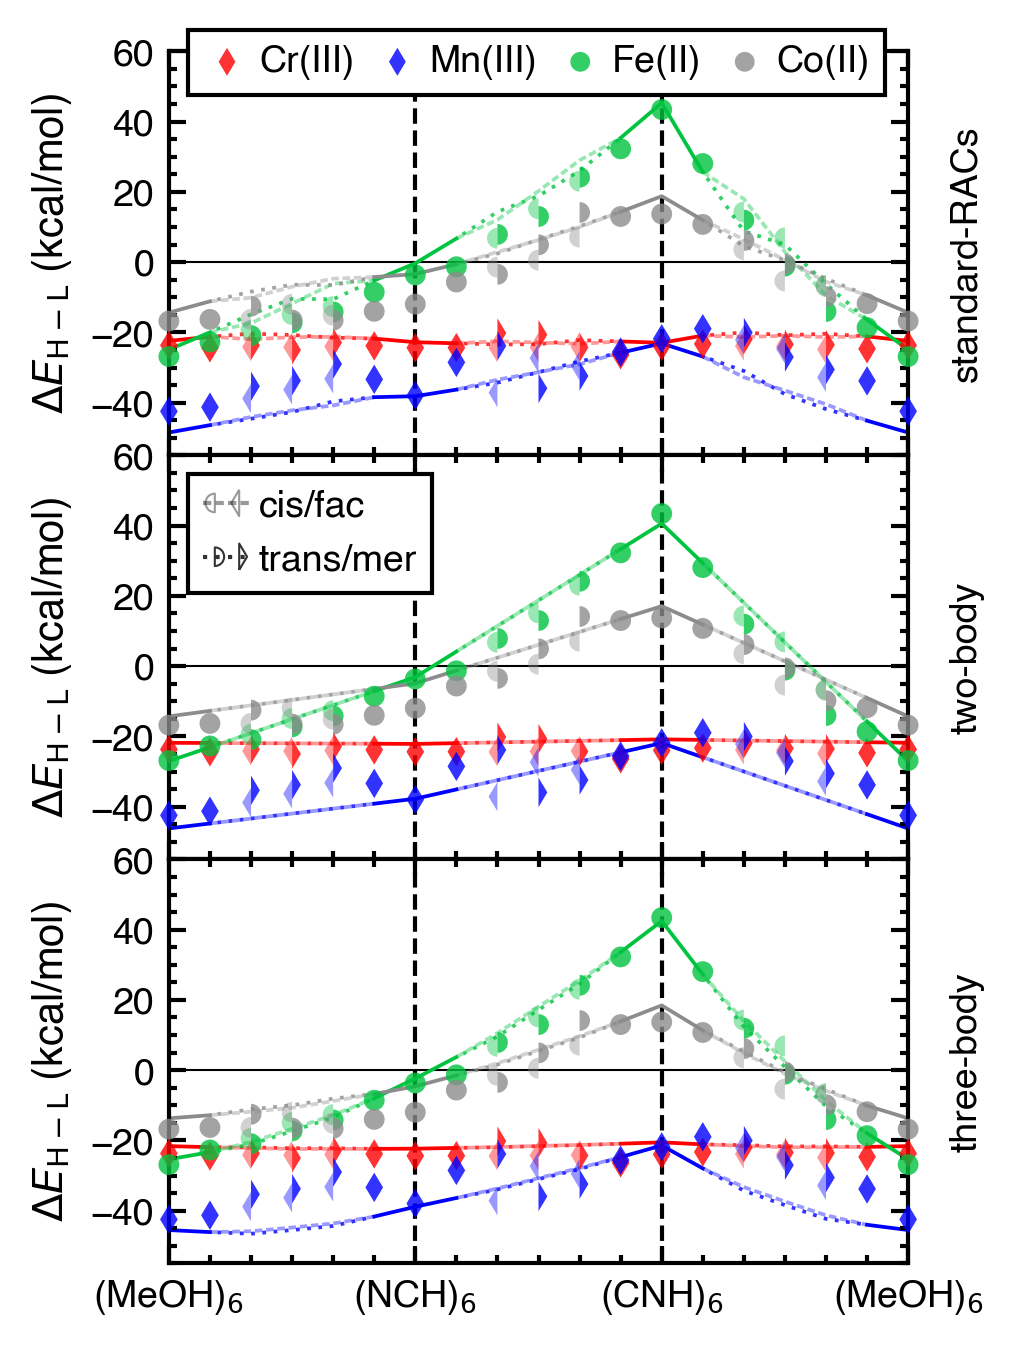

In [15]:
fig, _ = four_metal_plot(
    ["cr3", "mn3", "fe2", "co2"], nn_experiments, lowerlim=-55, upperlim=60
)
fig.savefig("plots/interpolation_plot_sse_nn_1.pdf")

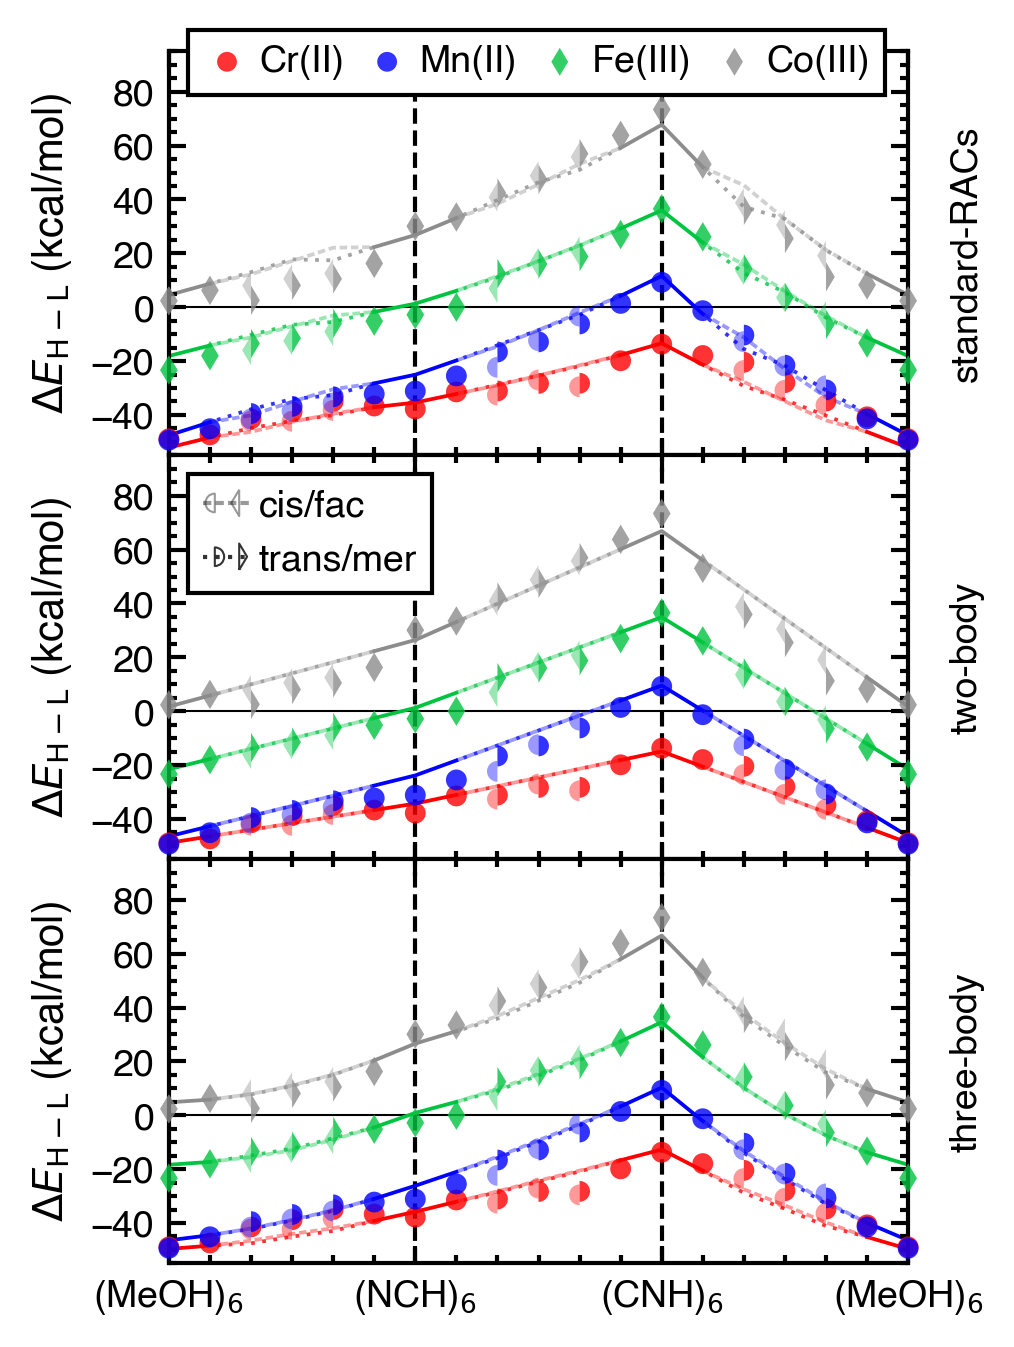

In [16]:
fig, _ = four_metal_plot(
    ["cr2", "mn2", "fe3", "co3"], nn_experiments, lowerlim=-55, upperlim=95
)
fig.savefig("plots/interpolation_plot_sse_nn_2.pdf")

# Average isomer splitting

In [17]:
def get_isomer_splits(experiment):
    isomer_splits = np.zeros([8 * 3, 3])
    for i, core in enumerate(unique_cores):
        for j, (a, b) in enumerate([(A, B), (B, C), (C, A)]):
            indices, _ = XY_curve(core, a, b)
            isomer_splits[i * 3 + j, 0] = (
                experiment.prediction[indices[2]] - experiment.prediction[indices[3]]
            )
            isomer_splits[i * 3 + j, 1] = (
                experiment.prediction[indices[4]] - experiment.prediction[indices[5]]
            )
            isomer_splits[i * 3 + j] = (
                experiment.prediction[indices[6]] - experiment.prediction[indices[7]]
            )
    return isomer_splits

In [18]:
# Assert that the split is constant for the three-body models:
for experiment in [krr_experiments[2], nn_experiments[2]]:
    splits = get_isomer_splits(experiment)
    np.testing.assert_allclose(splits[:, 0], splits[:, 1], atol=1e-4)
    np.testing.assert_allclose(splits[:, 1], splits[:, 2], atol=1e-4)

In [19]:
print(
    "MAD of standard-RACs KRR isomer split",
    f"{np.mean(abs(get_isomer_splits(krr_experiments[0]))):.3f}",
)
print(
    "MAD of standard-RACs isomer split",
    f"{np.mean(abs(get_isomer_splits(nn_experiments[0]))):.3f}",
)
print(
    "MAD of two-body KRR isomer split",
    f"{np.mean(abs(get_isomer_splits(krr_experiments[1]))):.3f}",
)
print(
    "MAD of two-body NN isomer split",
    f"{np.mean(abs(get_isomer_splits(nn_experiments[1]))):.3f}",
)
print(
    "MAD of three-body KRR isomer split",
    f"{np.mean(abs(get_isomer_splits(krr_experiments[2]))):.3f}",
)
print(
    "MAD of three-body NN isomer split",
    f"{np.mean(abs(get_isomer_splits(nn_experiments[2]))):.3f}",
)

MAD of standard-RACs KRR isomer split 3.002
MAD of standard-RACs isomer split 1.562
MAD of two-body KRR isomer split 0.000
MAD of two-body NN isomer split 0.000
MAD of three-body KRR isomer split 0.623
MAD of three-body NN isomer split 0.618
